# Dogs vs. Cats - Image Recognition from (almost) Scratch in 1 hour
For this example we will be looking at implementing VGG 16-layer CNN that won the ImageNet competion in 2016, and then finetuning it to recognize dog pictures vs cat pictures.

The Cats vs. Dogs probalem is actually an old Captcha challenge and is available on Kaggle at https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

The following code is heavily based on the Fast.ai course found here: http://course.fast.ai/lessons/lesson1.html

Before we get started, we assume that we have downloaded the dogs vs. cats competition data from Kaggle, and have unzipped them into train/ and test/ subdirectories in the dogscatsredux/ directory in DATA_HOME_PATH. Basically all we need to do after this is to set up a cats vs. dogs image recognition CNN is the following:

1. Create the directory structures that Keras is expecting the photos to be in:
  * valid/ directory
  * cats/ and dogs/ subdirectories in train/, test/, and /valid
  * sample/ directory
  * train/ and valid/ subdirectories in sample/
  * cats/ and dogs/ subdirectories in sample/train/ and sample/valid/
2. Copy & move pictures to the above directories 
  * Move a random 10% of pictures from train/ to valid/
  * Copy 200 random pictures from train/ to sample/train
  * Copy 20 random pictures from valid/ to sample/valid
  * For each of train/, valid/, sample/train, and sample/test, move all cat pics into cats/ and dog pics into dogs/  
  * For test/, move all pics into unknown/
3. Fine-tune the vgg model
  * load the existing model architecture and the pre-trained weights
  * remove the last dense softmax layer
  * replace with 2 class dense softmax layer 
  * retrain last layer's weights
4. Generate predictions
5. Validate predictions

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from __future__ import division,print_function
import os
from shutil import copyfile
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
import scipy
from sklearn.metrics import confusion_matrix
# Deep-learning related
from keras import backend as K
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers.pooling import GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.utils.data_utils import get_file

Using Theano backend.


In [2]:
# constants for directory paths
# assumes they already exist
NBS_HOME_PATH = '/home/honto/Online_Courses/fast_ai/fast_ai_coursework/deeplearning1/nbs'
DATA_HOME_PATH = '/home/honto/Online_Courses/fast_ai/fast_ai_coursework/deeplearning1/data/dogscatsredux'
MODEL_RESULTS_PATH = '/home/honto/Online_Courses/fast_ai/fast_ai_coursework/deeplearning1/results/dogscatsredux'

## 1) Create the directory structures that Keras is expecting the photos to be in:
* valid/ directory
* cats/ and dogs/ subdirectories in train/, test/, and /valid
* sample/ directory
* train/ and valid/ subdirectories in sample/
* cats/ and dogs/ subdirectories in sample/train/ and sample/valid/

In [ ]:
%mkdir $DATA_HOME_PATH/train/cats
%mkdir $DATA_HOME_PATH/train/dogs
%mkdir $DATA_HOME_PATH/valid
%mkdir $DATA_HOME_PATH/valid/cats
%mkdir $DATA_HOME_PATH/valid/dogs
%mkdir $DATA_HOME_PATH/test/unknown
%mkdir $DATA_HOME_PATH/sample
%mkdir $DATA_HOME_PATH/sample/train
%mkdir $DATA_HOME_PATH/sample/train/cats
%mkdir $DATA_HOME_PATH/sample/train/dogs
%mkdir $DATA_HOME_PATH/sample/valid
%mkdir $DATA_HOME_PATH/sample/valid/cats
%mkdir $DATA_HOME_PATH/sample/valid/dogs
%mkdir $MODEL_RESULTS_PATH

## 2) Copy & move pictures to the above directories 
* Move a random 10% of pictures from train/ to valid/
* Copy 200 random pictures from train/ to sample/
* For each of train/, valid/, sample/train, and sample/test, move all cat pics into cats/ and dog pics into dogs/ 
* For test/, move all pics into unknown/

In [ ]:
%cd $DATA_HOME_PATH/train

In [ ]:
%%bash
ls | wc -l

In [ ]:
# move 2500 from train/ to valid/
# get all the pic filenames (['cat.8033.jpg', 'cat.6541.jpg', ...])
g = glob('*.jpg')
# randomly permute g and get the first  
valid_filenames = np.random.permutation(g)
for i in range(2500):
    os.rename(valid_filenames[i], DATA_HOME_PATH + '/valid/' + valid_filenames[i])

In [ ]:
# Copy 200 random pictures from train/ to sample/train
g = glob('*.jpg')
# randomly permute g and get the first  
valid_filenames = np.random.permutation(g)
for i in range(200):
   copyfile(valid_filenames[i], DATA_HOME_PATH + '/sample/train/' + valid_filenames[i])

In [ ]:
# Copy 20 random pictures from valid/ to sample/train
%cd $DATA_HOME_PATH/dogscatsredux/valid
g = glob('*.jpg')
# randomly permute g and get the first  
valid_filenames = np.random.permutation(g)
for i in range(20):
   copyfile(valid_filenames[i], DATA_HOME_PATH + '/sample/valid/' + valid_filenames[i])

In [ ]:
# For each of train/, valid/, sample/train, and sample/test, move all cat pics into cats/ and dog pics into dogs/  
%cd $DATA_HOME_PATH/train
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA_HOME_PATH/valid
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA_HOME_PATH/sample/train
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA_HOME_PATH/sample/valid
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $NBS_HOME_PATH

In [ ]:
# For test/, move all pics into unknown/
%cd $DATA_HOME_PATH/test
%mv *.jpg unknown/
%cd $NBS_HOME_PATH

## 3) Fine-tune the vgg model
* load the existing model architecture and weights
* remove the last dense softmax layer
* replace with 2 class dense softmax layer 
* retrain last layer's weights

In [24]:
BATCH_SIZE = 32
NO_EPOCHS = 3

In [4]:
# Helper functions to build the VGG 16 model

# VGG architecture expects to have the layers in bgr order when most pictures are in rgb
# Also, VGG is optimized when levels are 0-meaned to the Imagenet training set RGB levels
vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((3,1,1))
def vgg_preprocess(x):
    x = x - vgg_mean
    return x[:, ::-1] # reverse axis rgb->bgr

# to build the model 
def Vgg16():
    FILE_PATH = 'http://www.platform.ai/models/'
    
    model = Sequential()
    # 0-mean
    model.add(Lambda(vgg_preprocess, input_shape=(3,224,224), output_shape=(3,224,224)))
    
    # 2 layers of 64 3x3 filters
    model.add(ZeroPadding2D((1,1),input_shape=(3,224,224)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    # Max-pooling to reduce image to 112x112 pixels
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    # 2 layers of 128 3x3 filters
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    # Max-pooling to reduce image to 56x56 pixels
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    # 3 layers of 256 3x3 filters
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    # Max-pooling to reduce image to 28x28 pixels
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    # 3 layers of 512 3x3 filters
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    # Max-pooling to reduce image to 14x14 pixels
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    # 3 layers of 512 3x3 filters
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    # Max-pooling to reduce image to 7x7 pixels
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    # flatten to one long 25088-D vector
    model.add(Flatten())
    # 2 additional fully connected layers of 4096 nodes
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    # final fully connected softmax layer to predict probabilities for each of the 1000 image classes
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='softmax'))
    
    # load the pre-trained weights so we don't have to train it with the entire Imagenet dataset
    fname = 'vgg16.h5'
    model.load_weights(get_file(fname, FILE_PATH+fname, cache_subdir='models'))

    return model

model = Vgg16()

Since the model is trained on 1000 types with multiple types of dogs and cats, we want to adapt this model to predict dogs vs. cats. To do this we will remove the last fully connect softmax layer with 1000 nodes to one with 2 nodes - one for cats and one for dogs.

In [5]:
# remove the last dense softmax layer
model.pop()
# set the other layer weights to NOT get trained during fine tuning
for l in model.layers:
    l.trainable = False
# add the dense layer
# input dimension is detected from the last layer in the current model
model.add(Dense(output_dim=2, activation='softmax'))
# let's see the layers 
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [6]:
# to configure the learning process (optimizer, loss, metric)
model.compile(optimizer=Adam(lr=0.001), 
              loss='categorical_crossentropy',
              metrics=['accuracy']
             )

Now we get the dogs and cats images we downloaded from Kaggle and "fine-tune" the model (i.e. re-train the last layer's 8194 weights)

In [9]:
# First we get the images from train and valid in batches. 
# We have to use Keras' generator methods when doing things in batches.
img_gen = image.ImageDataGenerator()
# read from directory
# Class labels are inferred from sub-directory structure
train_batches = img_gen.flow_from_directory(DATA_HOME_PATH + '/train/', 
                                            target_size=(224,224),
                                            class_mode='categorical', 
                                            # categorical returns 2-D OHE truth labels
                                            batch_size = BATCH_SIZE,
                                            shuffle=True
                                           )
val_batches = img_gen.flow_from_directory(DATA_HOME_PATH + '/valid/', 
                                          target_size=(224,224),
                                          class_mode='categorical',
                                          batch_size = 1,
                                          shuffle=False
                                         )

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [25]:
# now we fit the model
model.fit_generator(train_batches, 
                    samples_per_epoch=train_batches.nb_sample, 
                    nb_epoch=NO_EPOCHS, 
                    verbose=1, 
                    validation_data=val_batches, 
                    nb_val_samples=val_batches.nb_sample
                   )

Epoch 1/3
22500/22500 [==============================] - 11628s - loss: 0.1202 - acc: 0.9763 - val_loss: 0.1030 - val_acc: 0.9816

In [ ]:
# Remind us what our loss functions and performance metric is
model.metrics_names

Accuracy is basically the % of correct predictions.
Categorical cross-entropy can be thought of as a more nuanced accuracy measure where it takes into account the confidence of each prediction.

In [26]:
# let's save the weights so we don't have to re-train in the future
model.save_weights(MODEL_RESULTS_PATH + '/finetune1_3epochs.h5')
# model.load_weights(MODEL_RESULTS_PATH + '/finetune1.h5')

## 4) Generate predictions
Now let us generate predictions with the validation data

In [27]:
# generate predictions (20 x 2 array of probs)
val_pred = model.predict_generator(val_batches, val_batches.nb_sample)
val_pred_probs = val_pred[:,0]
# what about the labels/classes?
val_pred_lbls = np.argmax(val_pred, axis=1)

## 5) Validate Predictions
To validate predictions, we will sample and examine the following:

1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (ie those with highest probability that are correct)
4. The most incorrect labels of each class (ie those with highest probability that are incorrect)
5. The most uncertain labels (ie those with probability closest to 0.5).

In [13]:
# first, let's get the filenames so we can view the pictures
filenames = val_batches.filenames
# Number of images to view for each visualization task
n_view = 4
# the truth labels
val_lbls = val_batches.classes
val_lbls

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

Plotting helper functions

In [28]:
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
        
        
def plots_idx(idx, titles=None):
    # idx = index of the filenames we want to plot
    plots([image.load_img(DATA_HOME_PATH + '/valid/' + filenames[i]) for i in idx], titles=titles)

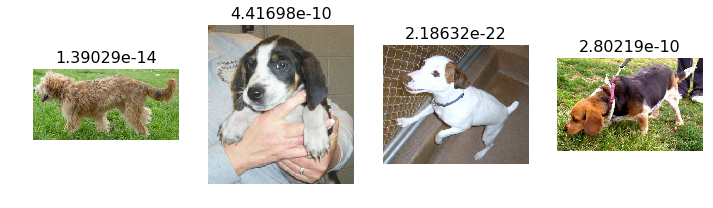

In [29]:
# 1 - correct labels
correct_idx = np.where(val_pred_lbls==val_lbls)[0]
# randomize
correct_idx_sample = np.random.permutation(correct_idx)[:n_view]
# plot 
plots_idx(correct_idx_sample, val_pred_probs[correct_idx_sample])

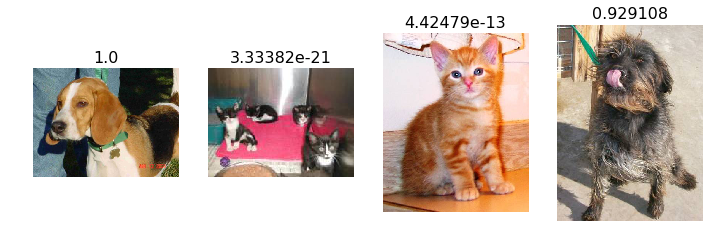

In [30]:
# 2 - random incorrect labels
incorrect_idx = np.where(val_pred_lbls!=val_lbls)[0]
# randomize
incorrect_idx_sample = np.random.permutation(incorrect_idx)[:n_view]
# plot 
plots_idx(incorrect_idx_sample, val_pred_probs[incorrect_idx_sample])

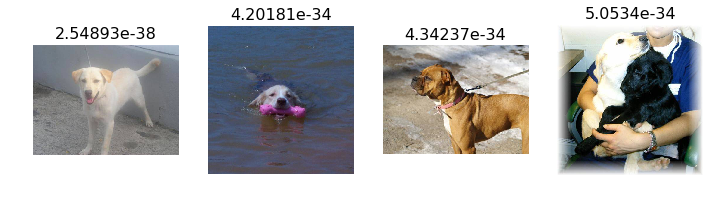

In [31]:
# 3 - Most correct dogs
correct_dogs_idx = np.where((val_pred_lbls==1) & (val_pred_lbls==val_lbls))[0]
most_correct_dogs = np.argsort(val_pred_probs[correct_dogs_idx])[:n_view]
# plot 
plots_idx(correct_dogs_idx[most_correct_dogs], val_pred_probs[correct_dogs_idx][most_correct_dogs])


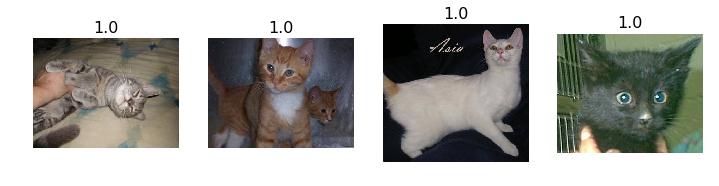

In [20]:
# 3b - Most correct cats
correct_cats_idx = np.where((val_pred_lbls==0) & (val_pred_lbls==val_lbls))[0]
most_correct_cats = np.argsort(val_pred_probs[correct_cats_idx])[::-1][:n_view] # desc sort
# plot 
plots_idx(correct_cats_idx[most_correct_cats], val_pred_probs[correct_cats_idx][most_correct_cats])


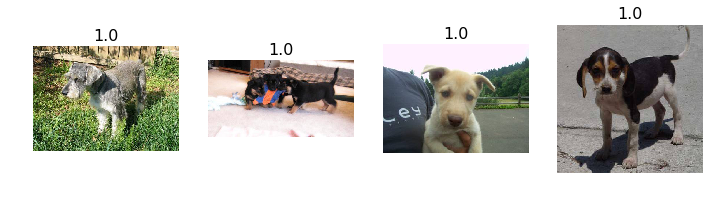

In [32]:
# 4 - Most Incorrect predictions. First, those that are most confident are cats but are dogs
incorrect_dogs_idx = np.where((val_pred_lbls==0) & (val_pred_lbls!=val_lbls))[0]
most_incorrect_dogs = np.argsort(val_pred_probs[incorrect_dogs_idx])[::-1][:n_view] # desc sort
# plot 
plots_idx(incorrect_dogs_idx[most_incorrect_dogs], val_pred_probs[incorrect_dogs_idx][most_incorrect_dogs])

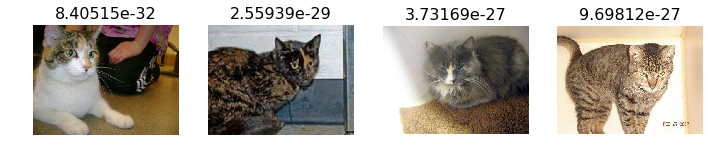

In [33]:
# 4b -  Most Incorrect predictions. Those that are most confident are dogs but are cats
incorrect_cats_idx = np.where((val_pred_lbls==1) & (val_pred_lbls!=val_lbls))[0]
most_incorrect_cats = np.argsort(val_pred_probs[incorrect_cats_idx])[:n_view] # smallest
# plot 
plots_idx(incorrect_cats_idx[most_incorrect_cats], val_pred_probs[incorrect_cats_idx][most_incorrect_cats])

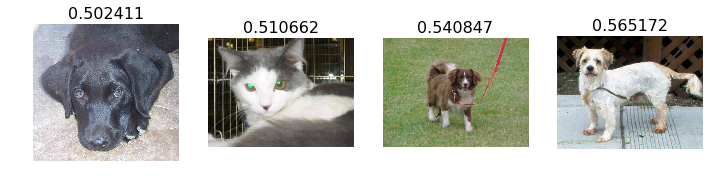

In [23]:
# 5 - The most uncertain labels (ie those with probability closest to 0.5)
uncertainty = np.abs(0.5-val_pred_probs)
most_uncertain = np.argsort(uncertainty)[:n_view] # argsort returns an index array
# plot 
plots_idx(most_uncertain, val_pred_probs[most_uncertain])